In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import copy

from pycbc import conversions, psd
from pycbc.filter import match

from simple_pe.param_est import metric
from pesummary.utils.samples_dict import SamplesDict
from pesummary.gw.conversions import convert

In [2]:
import logging
_logger = logging.getLogger('PESummary')
_logger.setLevel(logging.CRITICAL + 10)

## Read in PSDs, etc

In [3]:
ifos = ['H1', 'L1', 'V1']

psds = {'H1': 'aLIGOMidHighSensitivityP1200087',
        'L1': 'aLIGOMidHighSensitivityP1200087',
        'V1': 'AdVMidHighSensitivityP1200087',
        'f_low': 20.,
        'f_high': 8192,
        'length': 32
        }

psds['delta_f'] = 1. / psds['length']

approximant = 'IMRPhenomXPHM'

In [4]:
pycbc_psd = {}
for ifo in ifos:
    pycbc_psd[ifo] = psd.analytical.from_string(psds[ifo], psds['length'] * psds['f_high'] + 1, psds['delta_f'],
                                                psds['f_low'])

pycbc_psd['harm'] = 3. / sum([1. / pycbc_psd[ifo] for ifo in ifos])

/home/spxsf2/miniconda3/envs/igwn-py39/lib/python3.9/site-packages/pycbc/types/array.py:390: RuntimeWarning: divide by zero encountered in true_divide
  return self._data.__rtruediv__(other)


## Parameters

GW190412-like signal

In [5]:
m1 = 30.
m2 = 10.
mc = conversions.mchirp_from_mass1_mass2(m1, m2)
eta = conversions.eta_from_mass1_mass2(m1, m2)
s1z = 0.3
s2z = 0.
chi_eff = conversions.chi_eff(m1, m2, s1z, s2z)
chi_p = 0.4
a_1 = 0.5
a_2 = 0
tilt_1 = np.arctan2(4, 3)
snr = 18

In [6]:
print(mc, eta)

14.650780257917608 0.1875


## Spin directions

In [7]:
params = {'mass_1': m1,
          'mass_2': m2,
          'chi_eff': chi_eff,
          'chi_p2': chi_p **2,
        }

In [8]:
dx_directions = ['chi_p2', 'chi_eff']

In [11]:
g_spin = metric.find_metric_and_eigendirections(params, dx_directions, snr, psds['f_low'], pycbc_psd['harm'], 
                                     approximant, tolerance=0.01, max_iter=20)

In [12]:
print(g_spin.dx_directions)
print(g_spin.metric)
print(g_spin.evec)
print(g_spin.evals)

['chi_p2', 'chi_eff']
[[ 0.25613845  3.80505734]
 [ 3.80505734 57.31171337]]
[[-0.99780233 -0.06626099]
 [ 0.06626099 -0.99780233]]
[3.49759344e-03 5.75644253e+01]


In [13]:
spin_ellipse = g_spin.generate_ellipse()

In [14]:
spin_mat = g_spin.generate_match_grid(npts=21, mismatch=g_spin.mismatch*(1.3)**2)
spin_p = np.exp(-snr**2/2 * (1 - spin_mat['match']))

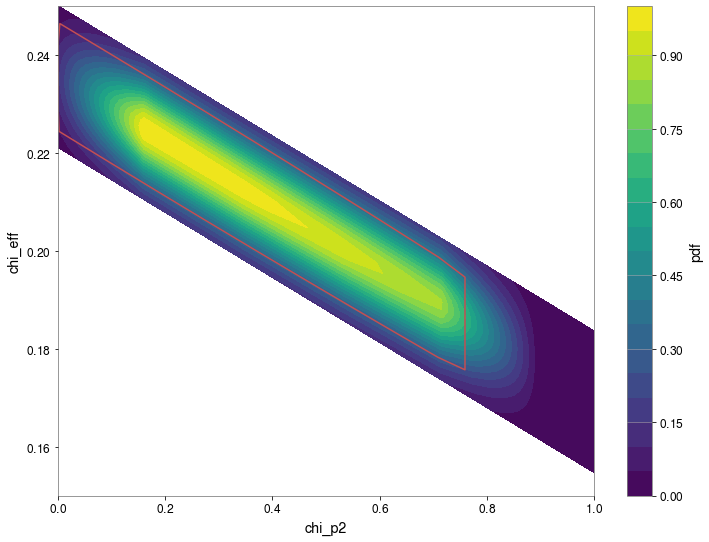

In [15]:
plt.figure(figsize=(12, 9))
plt.contourf(spin_mat.samples[0], spin_mat.samples[1], spin_p, levels=np.linspace(0, 1, 21))
plt.xlabel(spin_mat.keys()[0])
plt.ylabel(spin_mat.keys()[1])
plt.colorbar(label='pdf')
plt.plot(spin_ellipse.samples[0], spin_ellipse.samples[1], 'r')
plt.grid()
plt.xlim([0,1])
plt.ylim([0.15, 0.25])

plt.savefig('spin_prec_measurement.png')

## Three dimensions with projection

Note: we are using "chi_eff", but that's just putting the same spin on both BHs, so probably don't need to worry about the fact that it's not the best measured spin direction.

In [16]:
params = {'chirp_mass': mc,
          'symmetric_mass_ratio': eta,
          'chi_eff': chi_eff,
          'chi_p2': chi_p **2,
        }

In [17]:
dx_directions = ['chirp_mass', 'chi_p2', 'chi_eff']

In [18]:
g_3d = metric.find_metric_and_eigendirections(params, dx_directions, snr, psds['f_low'], pycbc_psd['harm'], 
                                     approximant, tolerance=0.01, max_iter=20)

## Two dimensional projections

In [19]:
keep_dirs = {'mc_chip':['chirp_mass','chi_p2'],
            'chip_chieff': ['chi_p2', 'chi_eff'],
            'mc_chieff':['chirp_mass', 'chi_eff']}

In [20]:
g_2d = {}

In [23]:
npts = 21

In [ ]:
for key, dx_keep in keep_dirs.items():
    g_2d[key] = metric.find_metric_and_eigendirections(params, dx_keep, snr, psds['f_low'], pycbc_psd['harm'], 
                                     approximant, tolerance=0.01, max_iter=20)
    

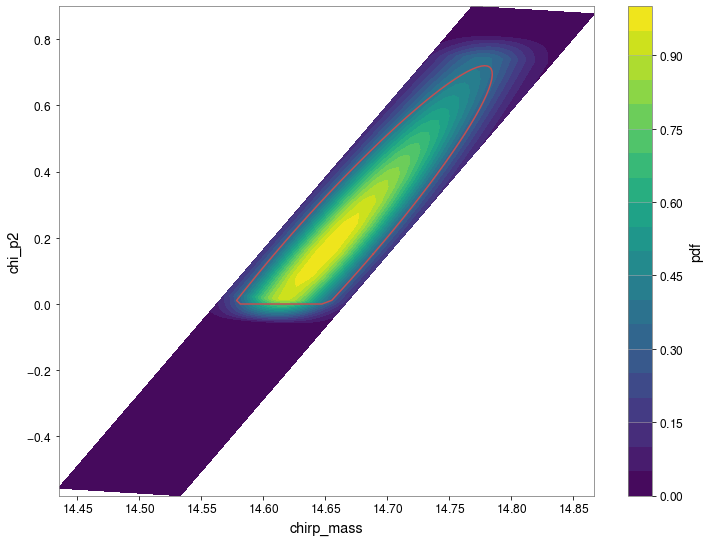

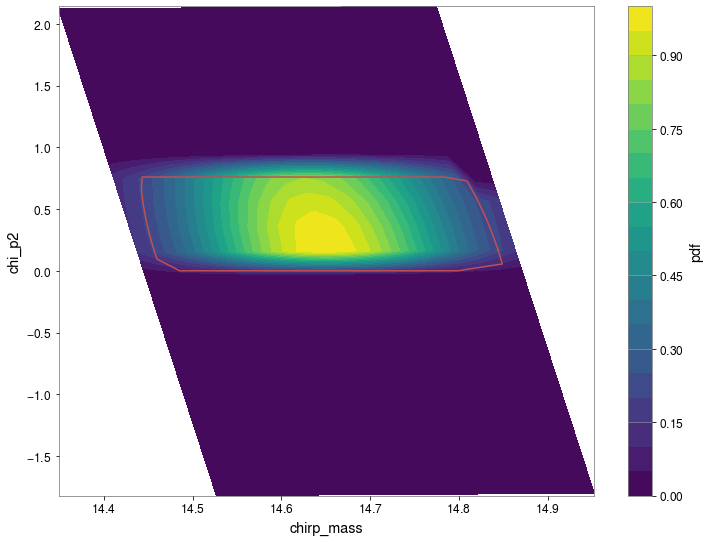

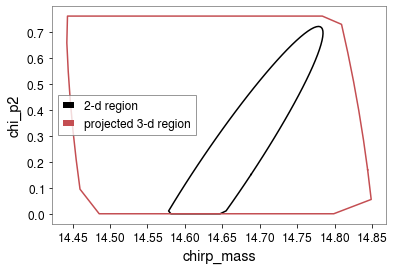

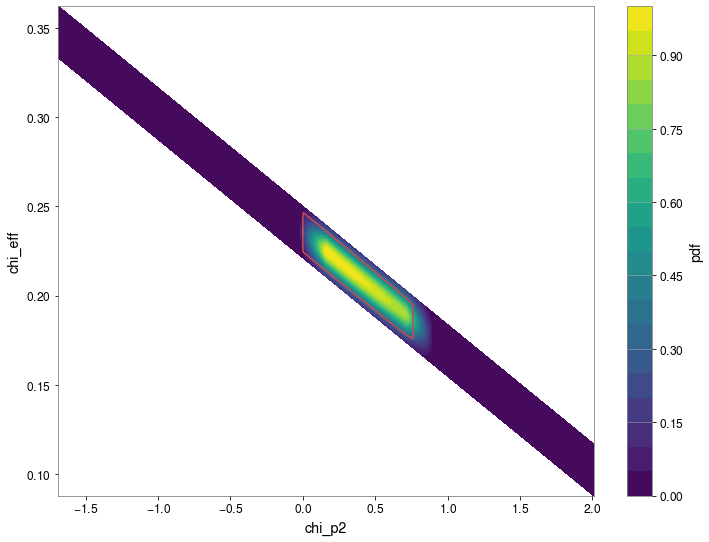

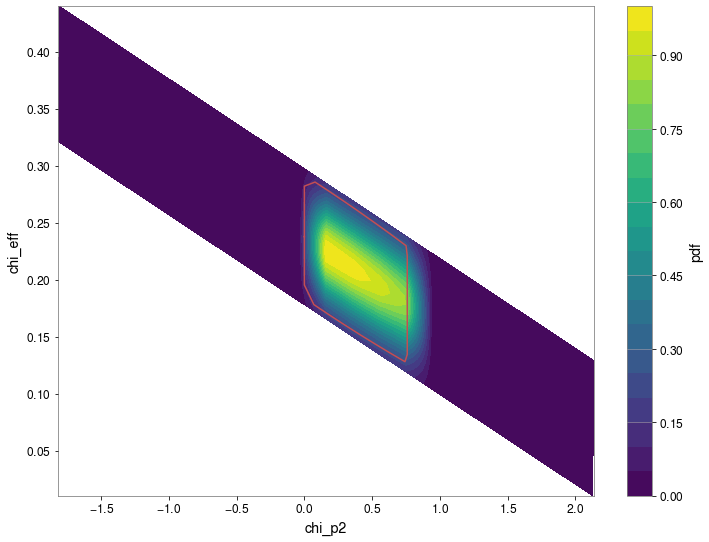

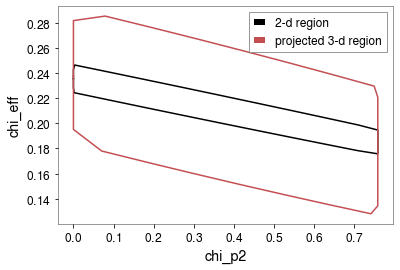

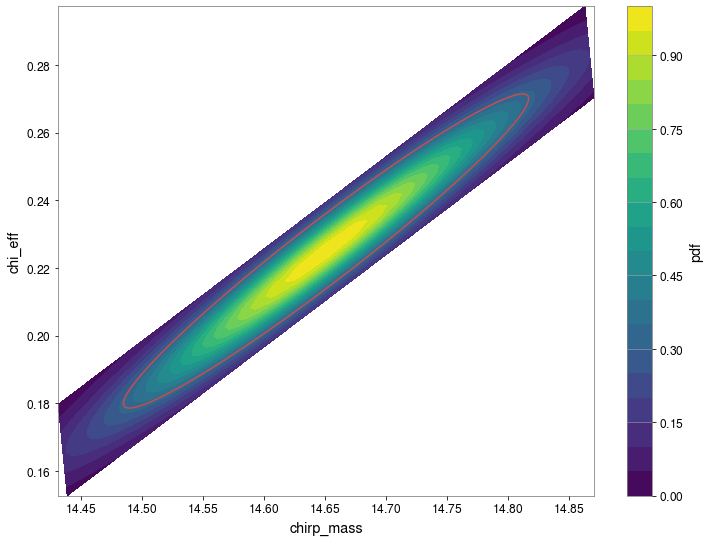

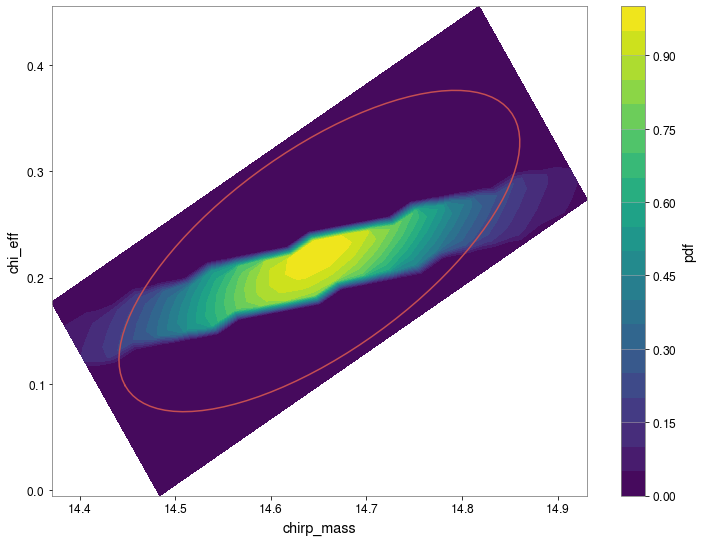

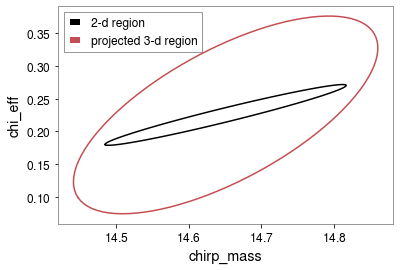

In [35]:
for key, dx_keep in keep_dirs.items():
    proj_dir = [x for x in dx_directions if x not in keep_dirs[key] ][0]
    
    # generate 2d regions
    ellipse = g_2d[key].generate_ellipse()
    matches = g_2d[key].generate_match_grid(npts=npts, mismatch=g_2d[key].mismatch*(1.3)**2)
    prob = np.exp(-snr**2/2 * (1 - matches['match']))
    
    # plot them
    plt.figure(figsize=(12, 9))
    plt.contourf(matches.samples[0], matches.samples[1], prob, levels=np.linspace(0, 1, 21))
    plt.xlabel(matches.keys()[0])
    plt.ylabel(matches.keys()[1])
    plt.colorbar(label='pdf')
    plt.plot(ellipse.samples[0], ellipse.samples[1], 'r')
    plt.grid()
    plt.savefig('ellipse_%s_2d.png' % key)
    
    # generate 3d regions
    g_3d.project_metric(dx_keep)
    three_d_ellipse = g_3d.generate_ellipse(projected=True)
    proj_matches = g_3d.generate_match_grid(projected=True, mismatch = g_3d.mismatch * (1.1)**2, npts=npts)
    proj_prob = np.exp(-snr**2/2 * (1 - proj_matches['match']))
    
    # and plot
    plt.figure(figsize=(12, 9))
    plt.contourf(proj_matches.samples[0].reshape([npts,npts]), proj_matches.samples[1].reshape([npts,npts]), 
                 proj_prob.reshape([npts,npts]), levels=np.linspace(0, 1, npts))
    plt.xlabel(proj_matches.keys()[0])
    plt.ylabel(proj_matches.keys()[1])
    plt.colorbar(label='pdf')
    plt.plot(three_d_ellipse.samples[0], three_d_ellipse.samples[1], 'r')
    plt.grid()
    plt.savefig('ellipse_%s_project_%s.png' % (key, proj_dir))

    # compare 2-d and projected region
    plt.figure()
    plt.plot(ellipse.samples[0], ellipse.samples[1], 'k', label='2-d region')
    plt.plot(three_d_ellipse.samples[0], three_d_ellipse.samples[1], 'r', label='projected 3-d region')
    plt.xlabel(three_d_ellipse.keys()[0])
    plt.ylabel(three_d_ellipse.keys()[1])
    plt.grid()
    plt.legend()
    plt.savefig('ellipse_compare_%s_project_%s.png' % (key, proj_dir))


Generate 4-d metric and samples

In [37]:
dx_directions = ['chirp_mass', 'chi_p2', 'chi_eff', 'symmetric_mass_ratio']

In [38]:
g_4d = metric.find_metric_and_eigendirections(params, dx_directions, snr, psds['f_low'], pycbc_psd['harm'], 
                                     approximant, tolerance=0.01, max_iter=20)

In [47]:
import corner

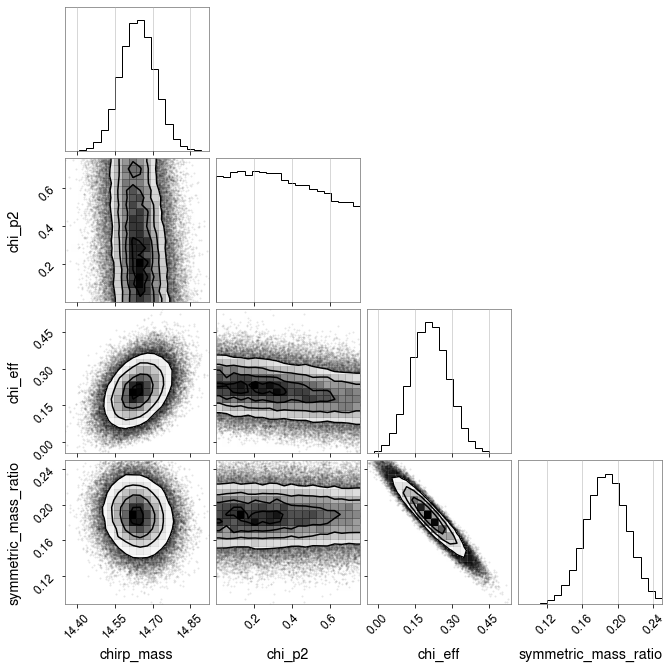

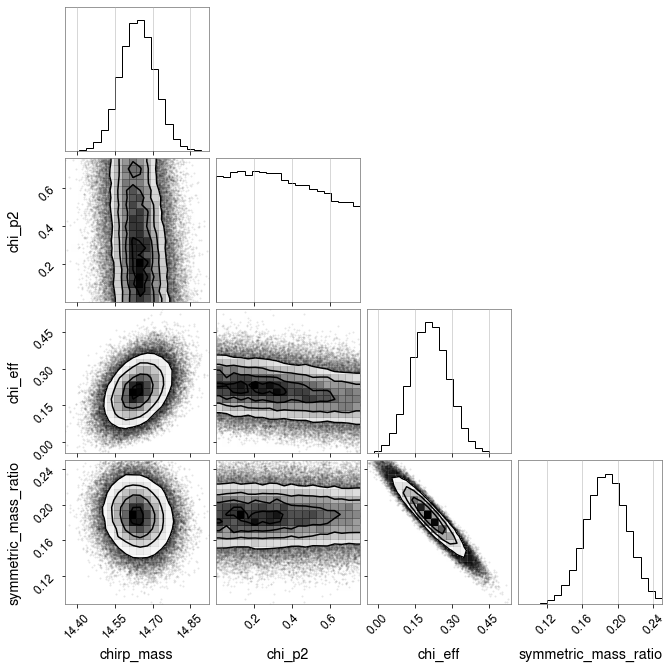

In [48]:
corner.corner(samps)

In [49]:
corner.corner?